In [278]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy as scipy
import json


We extract the population map for 10 different fictitious cities. All cities in the datasets have 1000 locations that we must attempt to cover with our antennas.

Text(0.5, 1.0, 'Population of North Carl, N=1000')

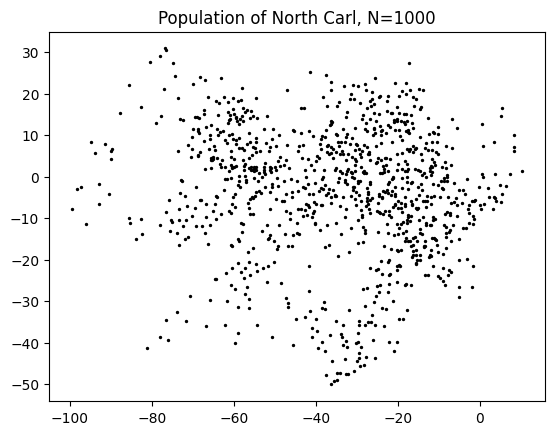

In [289]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[5]

with open('./data/population_{}.json'.format(city_name), 'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, s=2, facecolor='black')
plt.title('Population of {}, N={}'.format(city_name, len(x)))

Each antenna has an effective radius of coverage $R$. For antenna $i$ (at position $\vec{r}_i$), its coverage will be given by $d_R(i)$ and represents the number of houses that are within a radius of $R$ around location $\vec{r}_i$. We have that:
- Each antenna needs to cover the most houses in its coverage radius, so that all the antennas selected cover the most houses.
- Two antennas cannot be closer than $2R$ from each other, otherwise they will interfere.

For a given placement of $N$ antennas, its *total coverage* metric $COV$ is given by

$$COV = \sum_{i\in N} d_R (i) - B\sum_{i,j \in A} Interfere(i,j)$$

with 
$$Interfere(i,j) = \left\{ 
  \begin{array}{ c l }
    1 & \quad \textrm{if } ||\vec{r}_i - \vec{r}_i|| < 2R \\
    0                 & \quad \textrm{otherwise}
  \end{array}
\right.$$

Thus, maximum coverage is better, and interference between antennas is penalized ($B$ is taken as a large number). You can test the coverage of your antenna placement (given by a $2 \times N$ numpy array) on a given dataset with the following function. Take a moment to look at how close that problem is to that of a Maximum Independent Set, as seen in the workshop. 

In [280]:
def evaluate_coverage(data, placement, R_dist):
    x = np.array(data['x'])
    y = np.array(data['y'])
    B = len(x)
    coords = np.array([[x[i], y[i]] for i in range(len(x))])
    cost = 0
    for i in range(len(placement)):
        coord_i = np.array([placement[i]])
        for j in range(len(placement)):
            coord_j = np.array([placement[j]])
            if i != j:
                dist = scipy.spatial.distance.cdist(coord_i, coord_j)
                if dist < (2 + 1e-3)*R_dist:
                    cost += -B


        dist = scipy.spatial.distance.cdist(coord_i, coords)
        cov = np.sum(dist < R_dist)
        cost += cov

    if cost < 0:
        return -np.inf
    else:
        return cost


Let's test that coverage function:

In [281]:
#here is a test
placement = np.array([[0,0], [0,22], [22,0]])
cost = evaluate_coverage(data, placement, R_dist = 10) #here, the radius of coverage R is 10
print('total coverage of ', cost)
if cost == -np.inf:
    print('placement with inteference is infeasible')


total coverage of  74


# Your problem

Your team is tasked with delivering an optimal antenna layout for these 10 cities in the province of British Brunswick. The county has a limited budget; they can use at most 70 antennas in total! They must also ensure that at least 70 % of the population of each city is covered by the antenna system. Each antenna has an operating radius of 25 units (coverage radius $R=25$).

You must propose optimal positions for the antenna network for each city that leads to 1) the maximum coverage and 2) the least amount of antennas needed. You can test your proposed placements with the coverage function, and you'll have to make sure that no two antennas in your proposed placement are interfering with one another! Bonus points will be given to innovative solutions.

From this point on, you can propose whichever positions for your antennas. In order to give you some guidance, we show below how to propose a triangular grid of possible positions.

# Proposing some positions

Here is a way you can propose some positions on a triangular lattice, from which you could build a graph and solve the maximum independent set problem on it. Here, we build a triangular grid with a spacing slightly more than the coverage radius $R$.

In [282]:
def generate_triangular_grid(side_lengths, spacing, offset):
    rows, cols = side_lengths
    points = []
    for row in range(rows):
        for col in range(cols):
            # Calculate the x coordinate
            x = col * spacing
            # Offset every other row by half the side length
            if row % 2 == 1:
                x += spacing / 2
            # Calculate the y coordinate based on the row number
            y = row * (spacing * (3**0.5) / 2)  # Height of an equilateral triangle
            points.append([x + offset[0], y + offset[1]])
    return points

# Example usage:
R_antennas = 25
spacing = R_antennas*1.2 #this is arbitrary - you can try bigger and smaller grids!
offset = (x.min(), y.min())
side_lengths = (int(np.ceil((x.max() - x.min())/spacing)), int(np.ceil((y.max() - y.min())/spacing)))

grid_points = generate_triangular_grid(side_lengths = side_lengths, spacing = spacing, offset = offset) 

We then evaluate the coverage of each possible site:

In [283]:
z_coverage = np.zeros(len(grid_points))
coords = np.array([[x[i], y[i]] for i in range(len(x))])
for i in range(len(grid_points)):
    # val_y = y_test[i,j]
    start = np.array(grid_points[i])
    # print(start)
    dist = scipy.spatial.distance.cdist(np.array([start]), coords)
    truth_table = (dist <= R_antennas)
    cov = np.sum(truth_table)
    z_coverage[i] = cov

And plot the coverage radii and the individual coverage of each posposed antenna site.

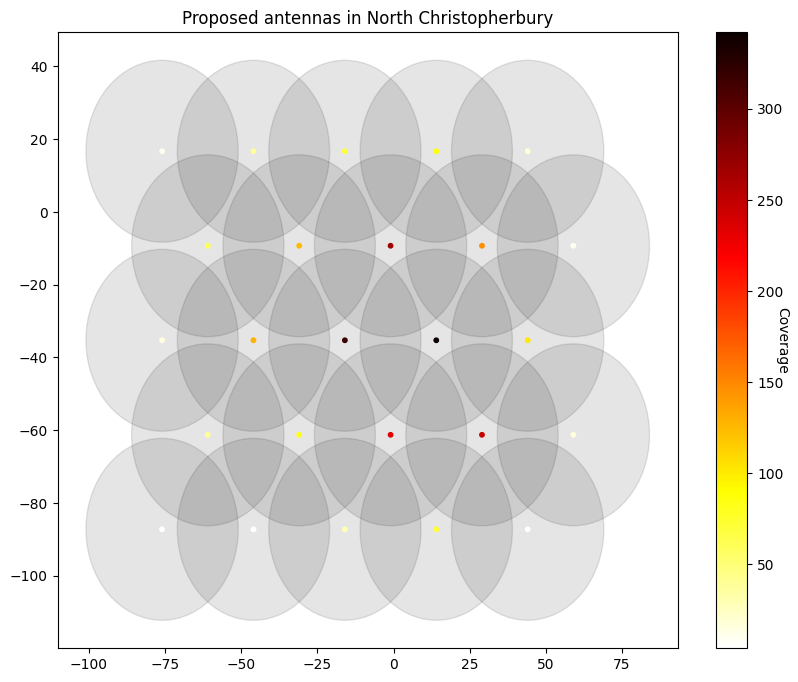

In [284]:
#plot the coverage map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plt.title('Proposed antennas in {}'.format(city_name))
ind = 0
for (xi, yi) in zip(np.array(grid_points)[:,0], np.array(grid_points)[:,1]):
    if z_coverage[ind] > 1e-3:
        circle = patches.Circle((xi, yi), R_antennas, edgecolor='black', facecolor='black', transform=ax.transData, alpha = 0.1)
        ax.add_patch(circle)
    ind += 1
scatter = ax.scatter(np.array(grid_points)[:,0], np.array(grid_points)[:,1], s=10, c = z_coverage, cmap = 'hot_r')

cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Coverage', rotation=270)

You can see that, when two radius overlap, we cannot place both of those antennas without running the risk of grave interference.

If that corresponds to too many choices of antennas positions and you can't solve this size of the problem yet, you might need to split the problem in smaller pieces you can treat more easily. 

You are free to propose different schemes for choosing possible antenna positions; this notebook is simply made to inspire you. Your task is then to:
1. (classical) select some potential positions for antennas
2. (quantum) formulate the optimization problem above on a form that can be solved on Pasqal's QPU
3. (quantum) perform the emulation and analyze your results.
4. (classical) compare the proposed antenna placements with the coverage evaluation functions.

Below is a possible solution, obtained purely classically.

In [285]:
import networkx as nx
from scipy.spatial import KDTree

#this creates a graph were two nodes (possible antenna positions) 
# are connected if they are within 2R of each other.
graph = nx.Graph()
edges = KDTree(grid_points).query_pairs(R_antennas*(2+1e-3))
graph.add_edges_from(edges)
nx.set_node_attributes(graph, values = {i:{'weight':z_coverage[i]} for i in range(len(z_coverage))})

#this is a greedy solution to the maximum weighted independent set problem.
def greedy_solution(graph : nx.Graph):
    new_graph = graph.copy()
    nodes = []
    while len(new_graph) > 1:
        attrs = nx.get_node_attributes(new_graph,'weight')
        list_indices = list(attrs.keys())
        all_weights = list(nx.get_node_attributes(new_graph,'weight').values())
        index_to_remove = np.argmax(all_weights)
        if all_weights[index_to_remove] < 1.0:
            break
        nodes.append(list_indices[index_to_remove])
        nodes_to_remove = [list_indices[index_to_remove]]
        for ind in new_graph.neighbors(list_indices[index_to_remove]):
            nodes_to_remove.append(ind)

        new_graph.remove_nodes_from(nodes_to_remove)
        if len(new_graph) == 0:
            break

    return nodes

total coverage of  700


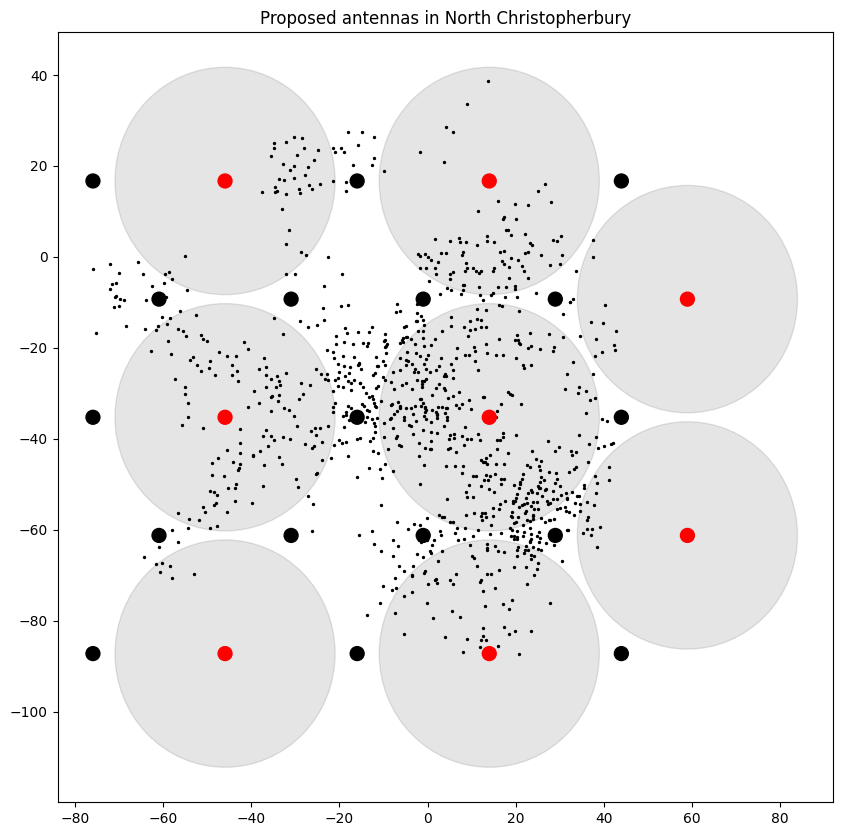

In [286]:
sol = greedy_solution(graph)
placement = []
colors = []
for i in range(len(z_coverage)):
    if i in sol:
        colors.append('red')
        placement.append(grid_points[i])
    else:
        colors.append('black')
placement = np.array(placement)
cost = evaluate_coverage(data, placement, R_antennas)
print('total coverage of ', cost)

#plot the coverage map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.title('Proposed antennas in {}'.format(city_name))
plt.scatter(x, y, s=2, facecolor='black')
ind = 0
for (xi, yi) in zip(np.array(grid_points)[:,0], np.array(grid_points)[:,1]):
    if ind in sol:
        circle = patches.Circle((xi, yi), R_antennas, edgecolor='black', facecolor='black', transform=ax.transData, alpha = 0.1)
        ax.add_patch(circle)
    ind += 1
plt.scatter(np.array(grid_points)[:,0], np.array(grid_points)[:,1], s=100, facecolor=colors, alpha = 1)
